# DP with RNN

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from utils_dp import DoublePendulum
from utils_dp import calc_double_E, verification



L1, L2 = 1, 1
M1, M2 = 1, 5
F1, F2 = 0.001, 0.001

init_theta1, init_omega1 = 0.4725, 0.0
init_theta2, init_omega2 = 0.3449, 0.0

dp = DoublePendulum(L1, L2, M1, M2, init_theta1, init_omega1, init_theta2, init_omega2, F1, F2)
tmax, dt = 3000, 0.005
t, y = dp.generate(tmax=tmax, dt=dt)

dp_params = {'M1': dp.M1, 'M2': dp.M2, 'L1': dp.L1, 'L2': dp.L2, 'g': dp.g, 'F1': dp.F1, 'F2': dp.F2}
# V, T, E = calc_double_E(y, **dp_params)

print('sequence length: {} ({} sec)'.format(len(y), tmax))
print('dt: {} (sec)\n'.format(dt))


subsampling = True

if subsampling:
    #### Fine dt for generation and subsample for learning
    sampling_step = 20    # sample a row for every the step.
    sampling_dt = dt*sampling_step
    sampling_ind = np.arange(0, t.shape[0]-1, sampling_step)
    sampling_t = t[sampling_ind]
    
    scaler = 1.0
    scaled_y = np.array(y)*scaler
    X = scaled_y[sampling_ind]

else:
    sampling_dt = dt
    sampling_t = t
    
    scaler = 1.0
    scaled_y = np.array(y)*scaler
    X = scaled_y
    

    
V, T, E = calc_double_E(X, **dp_params)
    
print('subsampled sequence length: {} ({} sec)'.format(len(X), tmax))
print('sampling dt: {} (sec)'.format(sampling_dt))

Length (L1,L2), Mass (M1,M2), and Friction (F1,F2) of a string: (1,1) (1,5), (0.001,0.001)
Initial theta(degree): 0.472500(27.072256),0.344900(19.761314)
Initial omega: 0.000000,0.000000
sequence length: 600001 (3000 sec)
dt: 0.005 (sec)

subsampled sequence length: 30000 (3000 sec)
sampling dt: 0.1 (sec)


Text(0, 0.5, 'Velocity (rad/s)')

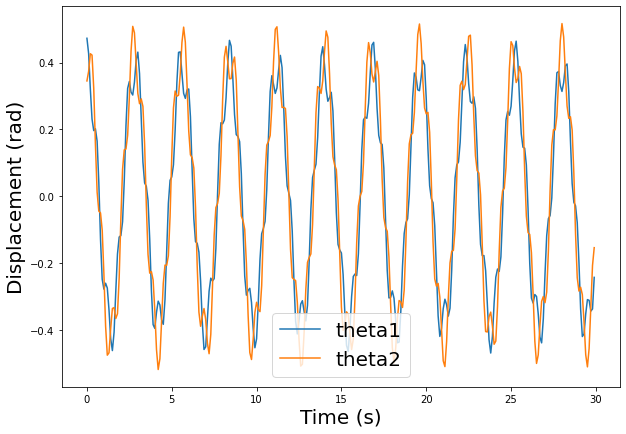

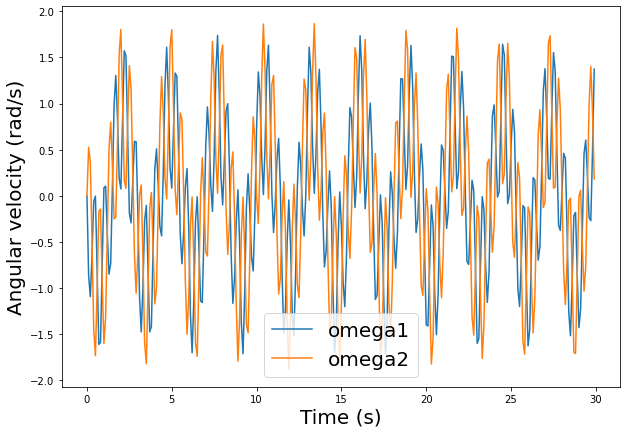

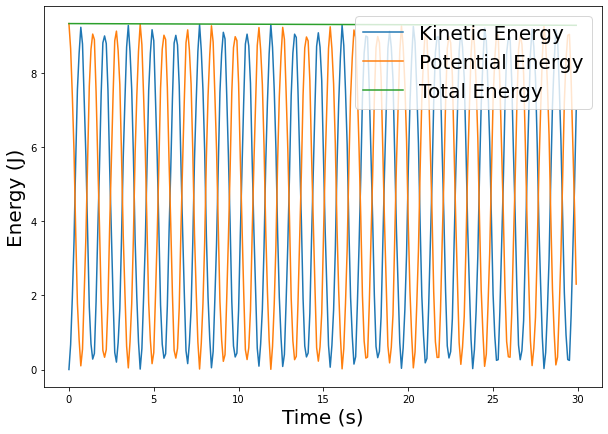

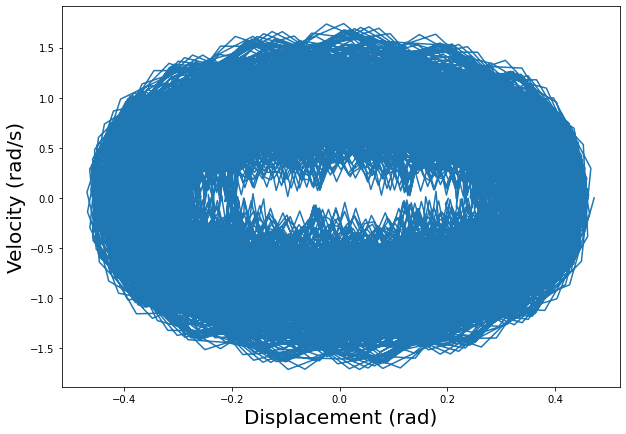

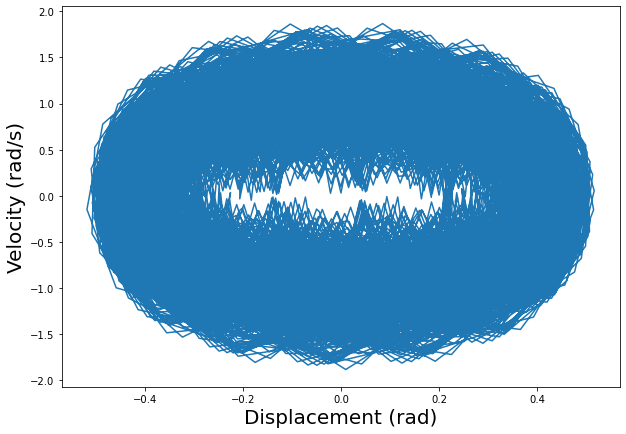

In [4]:
'''Plotting'''
# Unpack z and theta as a function of time
theta1, theta2 = X[:,0], X[:,2]
omega1, omega2 = X[:,1], X[:,3]

min_ind, max_ind = 0, len(X)//100
plt.figure(0, figsize=(10,7))
plt.plot(sampling_t[min_ind:max_ind], theta1[min_ind:max_ind], label='theta1')
plt.plot(sampling_t[min_ind:max_ind], theta2[min_ind:max_ind], label='theta2')
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Displacement (rad)', fontsize=20)
plt.legend(loc='lower center', fontsize=20)

plt.figure(1, figsize=(10,7))
plt.plot(sampling_t[min_ind:max_ind], omega1[min_ind:max_ind], label='omega1')
plt.plot(sampling_t[min_ind:max_ind], omega2[min_ind:max_ind], label='omega2')
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Angular velocity (rad/s)', fontsize=20)
plt.legend(loc='lower center', fontsize=20)

plt.figure(2, figsize=(10,7))
plt.plot(sampling_t[min_ind:max_ind], T[min_ind:max_ind], label='Kinetic Energy')
plt.plot(sampling_t[min_ind:max_ind], V[min_ind:max_ind], label='Potential Energy')
plt.plot(sampling_t[min_ind:max_ind], E[min_ind:max_ind], label='Total Energy')
plt.legend(loc='upper right', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Energy (J)', fontsize=20)

plt.figure(3, figsize=(10,7))
plt.plot(theta1, omega1)
plt.xlabel('Displacement (rad)', fontsize=20)
plt.ylabel('Velocity (rad/s)', fontsize=20)

plt.figure(4, figsize=(10,7))
plt.plot(theta2, omega2)
plt.xlabel('Displacement (rad)', fontsize=20)
plt.ylabel('Velocity (rad/s)', fontsize=20)

## Learning a model for the prediction task
- Input: `X(t-L), ..., X(t-1) (position, velocity)` of two objects
- Output: `X(t)` or `X(t), ..., X(t+W)`

In [5]:
'''
Data preprocessing for NN
'''
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset, Dataset


class DatasetRNN(Dataset):
    '''
    K to 1 task
    '''
    def __init__(self, data, input_len):
        self.data = data
        self.input_len = input_len

    def __getitem__(self, index):
        x = self.data[index:index+self.input_len]
        y = self.data[index+self.input_len]
        return x, y

    def __len__(self):
        return len(self.data) - self.input_len

device = torch.device("cuda:0")

X = torch.tensor(X, dtype=torch.float32, device=device)
input_len = 5

num_samples = X.shape[0]    # # of timesteps
input_dim = X.shape[1]    # (theta1, omega1, theta2, omega2)
output_dim = input_dim
train_X = X[:int(num_samples*0.6)]
valid_X = X[int(num_samples*0.6):int(num_samples*0.7)]
test_X = X[int(num_samples*0.7):]

batch_size = 64
train_loader = DataLoader(DatasetRNN(train_X, input_len), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(DatasetRNN(valid_X, input_len), batch_size=len(valid_X), shuffle=False)
test_loader = DataLoader(DatasetRNN(test_X, input_len), batch_size=len(test_X), shuffle=False)

print("data size: {}/{}/{}".format(len(train_X), len(valid_X), len(test_X)))

data size: 18000/3000/9000


In [6]:
from model import Net
from model import RuleEncoder as RuleEncoderMLP


class RuleEncoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RuleEncoder, self).__init__()
        self.net = nn.GRU(input_dim, output_dim, batch_first=True)

    def forward(self, x):
        return self.net(x)[1].squeeze(0)    # h_n from (output, h_n)


class DataEncoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DataEncoder, self).__init__()
        self.net = nn.GRU(input_dim, output_dim, batch_first=True)

    def forward(self, x):
        return self.net(x)[1].squeeze(0)    # h_n from (output, h_n)

    
hidden_dim = 64
db_hidden_dim = 32
n_layers = 4
rule_encoder = RuleEncoder(input_dim, hidden_dim)
data_encoder = DataEncoder(input_dim, hidden_dim)

model = Net(hidden_dim*2, output_dim, rule_encoder, data_encoder, hidden_dim=db_hidden_dim, n_layers=n_layers, skip=True, input_type='seq').to(device)

for batch_idx, batch_data in enumerate(valid_loader):
    batch_train_x = batch_data[0]
    batch_train_y = batch_data[1]
    break
    
with torch.no_grad():
    out = model(batch_train_x, alpha=0.0)

In [7]:
model

Net(
  (rule_encoder): RuleEncoder(
    (net): GRU(4, 64, batch_first=True)
  )
  (data_encoder): DataEncoder(
    (net): GRU(4, 64, batch_first=True)
  )
  (net): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=4, bias=True)
  )
)

In [10]:
from torch.distributions.beta import Beta


# ret_dict = dict()

model_info = {'dataonly': {},
              'ours-beta1.0-scale50': {'beta': [1.0], 'scale': 50},
              'ours-beta1.0-scale20': {'beta': [1.0], 'scale': 20},
              'ours-beta0.1-scale50': {'beta': [0.1], 'scale': 50},
              'ours-beta0.1-scale20': {'beta': [0.1], 'scale': 20},
              'ours-beta1.0-scale10-lr0.0001': {'beta': [1.0], 'scale': 10, 'lr':0.0001},
              'ours-beta1.0-scale20-lr0.0001': {'beta': [1.0], 'scale': 20, 'lr':0.0001},
              'ours-beta1.0-scale30-lr0.0001': {'beta': [1.0], 'scale': 30, 'lr':0.0001},
              'ours-beta0.1-scale10-lr0.0001': {'beta': [0.1], 'scale': 10, 'lr':0.0001},
              'ours-beta0.1-scale20-lr0.0001': {'beta': [0.1], 'scale': 20, 'lr':0.0001},
             }

for model_type in ['ours-beta1.0-scale30-lr0.0001']:
    
    if model_type not in model_info:
        # default setting
        lr = 0.001
        rule_coeff = 0.0
        scale = 1.0
        beta_param = [1.0]
        alpha_distribution = Beta(float(beta_param[0]), float(beta_param[0]))
        model_params = {}
    else:
        model_params = model_info[model_type]
        lr = model_params['lr'] if 'lr' in model_params else 0.001
        rule_coeff = model_params['rule'] if 'rule' in model_params else 0.0
        scale = model_params['scale'] if 'scale' in model_params else 1.0
        beta_param = model_params['beta'] if 'beta' in model_params else [1.0]
        if len(beta_param) == 1:
            alpha_distribution = Beta(float(beta_param[0]), float(beta_param[0]))
        elif len(beta_param) == 2:
            alpha_distribution = Beta(float(beta_param[0]), float(beta_param[1]))
            
    print('model_type: {}\tscale:{}\tBeta distribution: Beta({})\tlr: {}\trule_coeff: {}'.format(model_type, scale, beta_param, lr, rule_coeff))


    ret_dict[model_type] = {}

    for seed in range(0,10):

        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


        if model_type == 'dataonly':
            merge = 'cat'
        elif model_type == 'dataonly-equal':
            merge = 'equal_cat'
        elif model_type.startswith('ours'):
            merge = 'cat'
        elif model_type.startswith('ruleonly'):
            merge = 'cat'
            
        skip = True
        hidden_dim = 64
        db_hidden_dim = 32
        n_layers = 4
        rule_encoder = RuleEncoder(input_dim, hidden_dim)
        data_encoder = DataEncoder(input_dim, hidden_dim)

        model = Net(hidden_dim*2, output_dim, rule_encoder, data_encoder, hidden_dim=db_hidden_dim, n_layers=n_layers, skip=skip, input_type='seq').to(device)

        rule_weight = torch.tensor(model.rule_encoder.net.all_weights[0][0])
        data_weight = torch.tensor(model.data_encoder.net.all_weights[0][0])
        
#         lr = 0.0001
        total_params = sum(p.numel() for p in model.parameters())
        print("total parameters: {}".format(total_params))

        loss_rule_func = lambda x,y: torch.mean(F.relu(x-y))    # if x>y, penalize it.
        loss_task_func = nn.L1Loss()    # return scalar (reduction=mean)
#         loss_task_func = nn.MSELoss()
        l1_func = nn.L1Loss()


        epochs = 300 if model_type.startswith('ours') else 100
        log_interval = 500
        valid_freq = 5
        saved_filename = 'dp-rnn-{}_{:.4f}_{:.1f}_{:.4f}_{:.1f}-seed{}.pt' \
                            .format(model_type, init_theta1, init_omega1, init_theta2, init_omega2, seed)
        saved_filename =  os.path.join('saved_models', saved_filename)
        print('saved_filename: {}\n'.format(saved_filename))
        
        from_data_only_model = False
        if from_data_only_model and model_type.startswith('ours'):
            trained_model_filename = 'dp-rnn-dataonly_{:.4f}_{:.1f}_{:.4f}_{:.1f}-seed{}.pt' \
                                .format(init_theta1, init_omega1, init_theta2, init_omega2, seed)
            trained_model_filename = os.path.join('saved_models', trained_model_filename)
            checkpoint = torch.load(trained_model_filename)

            model.load_state_dict(checkpoint['model_state_dict'])
            best_valid_loss = checkpoint['loss']
            print("trained_model {} is loaded. Best validation loss: {}".format(trained_model_filename, best_valid_loss))

            optimizer = optim.Adam(model.parameters(), lr=lr*0.1)
        else:
            best_valid_loss = float('inf')
            optimizer = optim.Adam(model.parameters(), lr=lr)

        # Training
        for epoch in range(1, epochs+1):
            model.train()
            for batch_idx, batch_data in enumerate(train_loader):
                batch_train_x = batch_data[0]
                batch_train_y = batch_data[1]

                optimizer.zero_grad()

                if model_type.startswith('dataonly'):
                    alpha = 0.0
                elif model_type.startswith('ruleonly'):
                    alpha = 1.0
                elif model_type.startswith('ours'):
                    alpha = alpha_distribution.sample().item()

                output = model(batch_train_x, alpha=alpha, merge=merge)    # only rule if alpha=1.    \hat{X}_{t+1}

                _, _, curr_E = calc_double_E(batch_train_x[:,-1,:], **dp_params)    # E(X_t)    Energy of X_t (Current energy)
                _, _, next_E = calc_double_E(batch_train_y, **dp_params)    # E(X_{t+1})    Energy of X_{t+1} (Next energy from ground truth)
                _, _, pred_E = calc_double_E(output, **dp_params)    # E(\hat{X}_t+1)    Energy of \hat{X}_{t+1} (Next energy from prediction)

                loss_task = loss_task_func(output, batch_train_y)    # state prediction
                loss_rule = loss_rule_func(pred_E, curr_E - 0.00001)    # energy damping by friction: E_{t+1}<=E_t
                loss_mae = l1_func(output, batch_train_y).item()
                if batch_idx == 0 and epoch == 1:
                    auto_scale = loss_cons.item() / loss_state.item()
                    print('loss_state: {}\t loss_rule: {}\t auto_scale: {}'.format(loss_state.item(), loss_cons.item(), auto_scale))
                    
                if model_type.startswith('dataonly'):
                    loss = loss_task + rule_coeff * loss_rule
                elif model_type.startswith('ours'):
                    if any("norm" in s for s in model_params):
                        loss = (alpha/(loss_rule.item()+1e-6)) * loss_rule + ((1-alpha)/loss_task.item()) * loss_task   # energy damping + state prediction
                    elif any('autoscale' in s for s in model_params):
                        loss = alpha * loss_rule + auto_scale * (1-alpha) * loss_task   # energy damping + state prediction
                    else:
                        loss = alpha * loss_rule + scale * (1-alpha) * loss_task   # energy damping + state prediction
                elif model_type.startswith('ruleonly'):
                    loss = loss_rule   # energy damping + state prediction

                loss.backward()
                optimizer.step()

#                 if batch_idx % log_interval == 0:
#                     print('[Train] Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tLoss_rule: {:.6f} (alpha: {:.4f})'.format(
#                         epoch, batch_idx * len(batch_train_x), len(train_loader.dataset),
#                         100. * batch_idx / len(train_loader), loss_mae, loss_cons.item(), alpha))


            # Evaluate on validation set
            if epoch % valid_freq == 0:
                model.eval()
                with torch.no_grad():
                    total_sample = len(valid_X)
                    valid_loss = 0
                    for valid_x, valid_y in valid_loader:
                        output = model(valid_x, alpha=0.0, merge=merge)
                        valid_loss += (l1_func(output, valid_y).item() * valid_x.shape[0] / total_sample)

                if valid_loss < best_valid_loss:
                    best_valid_loss = valid_loss
                    print('[Valid] Epoch: {} Loss: {:.6f} (alpha: 0.0)\t best model is updated %%%%'
                          .format(epoch, best_valid_loss))
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict':model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': best_valid_loss
                    }, saved_filename)
                else:
                    print('[Valid] Epoch: {} Loss: {:.6f} (alpha: 0.0)'.format(epoch, valid_loss))


        # Test
        rule_encoder = RuleEncoder(input_dim, hidden_dim)
        data_encoder = DataEncoder(input_dim, hidden_dim)

        model_eval = Net(hidden_dim*2, output_dim, rule_encoder, data_encoder, hidden_dim=db_hidden_dim, n_layers=n_layers, skip=skip, input_type='seq').to(device)

        checkpoint = torch.load(saved_filename)
        model_eval.load_state_dict(checkpoint['model_state_dict'])
        print("best model loss: {:.6f}\t at epoch: {}".format(checkpoint['loss'], checkpoint['epoch']))

        model_eval.eval()
        with torch.no_grad():
            total_sample = len(test_X)
            test_loss = 0
            for test_x, test_y in test_loader:
                output = model_eval(test_x, alpha=0.0, merge=merge)
                test_loss += (l1_func(output, test_y).item() * test_x.shape[0] / total_sample)  # sum up batch loss

        print('\nTest set: Average loss: {:.8f}\n'.format(test_loss))
        print('seed: {}'.format(seed))

        #### Check which parameters are updated.
        print('Is rule_weight NOT udpated: {}'.format(torch.allclose(rule_weight, torch.tensor(model.rule_encoder.net.all_weights[0][0]))))
        print('Is data_weight NOT udpated: {}'.format(torch.allclose(data_weight, torch.tensor(model.data_encoder.net.all_weights[0][0]))))


        #### Best model
        test_loss_alpha = []
        test_ratio_alpha = []
        alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
        for _alpha in alphas:
            model_eval.eval()

            with torch.no_grad():
                total_sample = len(test_X)
                test_loss, test_ratio = 0, 0
                for test_x, test_y in test_loader:
                    
                    if model_type.startswith('dataonly'):
                        output = model_eval(test_x, alpha=0.0, merge=merge)
                    elif model_type.startswith('ours'):
                        output = model_eval(test_x, alpha=_alpha, merge=merge)
                    elif model_type.startswith('ruleonly'):
                        output = model_eval(test_x, alpha=1.0, merge=merge)

                    test_loss += (l1_func(output, test_y).item() * test_x.shape[0] / total_sample)  # sum up batch loss

                    _, _, curr_E = calc_double_E(test_x[:,-1,:], **dp_params)
                    _, _, next_E = calc_double_E(test_y, **dp_params)
                    _, _, pred_E = calc_double_E(output, **dp_params)

                    test_ratio += (verification(curr_E, pred_E, threshold=0.0).item() * curr_E.shape[0] / total_sample)

            print('Test set: Average loss: {:.8f} (alpha:{})'.format(test_loss, _alpha))
            print("ratio of verified predictions: {:.6f} (alpha:{})".format(test_ratio, _alpha))

            test_loss_alpha.append(test_loss)
            test_ratio_alpha.append(test_ratio)


        ret_dict[model_type][seed] = {'test_loss': test_loss_alpha, 'test_ratio': test_ratio_alpha}
        print()
        print()
        print()


model_type: ours-beta1.0-scale30-lr0.0001	scale:30	Beta distribution: Beta([1.0])	lr: 0.0001	rule_coeff: 0.0
total parameters: 33252
saved_filename: saved_models/dp-rnn-ours-beta1.0-scale30-lr0.0001_0.4725_0.0_0.3449_0.0-seed0.pt

best model loss: 0.001094	 at epoch: 240

Test set: Average loss: 0.00118309

seed: 0
Is rule_weight NOT udpated: True
Is data_weight NOT udpated: True


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(T

Test set: Average loss: 0.00118309 (alpha:0.0)
ratio of verified predictions: 0.338778 (alpha:0.0)
Test set: Average loss: 0.00105094 (alpha:0.1)
ratio of verified predictions: 0.406222 (alpha:0.1)
Test set: Average loss: 0.00093534 (alpha:0.2)
ratio of verified predictions: 0.477889 (alpha:0.2)
Test set: Average loss: 0.00084470 (alpha:0.3)
ratio of verified predictions: 0.574000 (alpha:0.3)
Test set: Average loss: 0.00079242 (alpha:0.4)
ratio of verified predictions: 0.696333 (alpha:0.4)
Test set: Average loss: 0.00078392 (alpha:0.5)
ratio of verified predictions: 0.791556 (alpha:0.5)
Test set: Average loss: 0.00083447 (alpha:0.6)
ratio of verified predictions: 0.876222 (alpha:0.6)
Test set: Average loss: 0.00094432 (alpha:0.7)
ratio of verified predictions: 0.936778 (alpha:0.7)
Test set: Average loss: 0.00109561 (alpha:0.8)
ratio of verified predictions: 0.978778 (alpha:0.8)
Test set: Average loss: 0.00127327 (alpha:0.9)
ratio of verified predictions: 0.992444 (alpha:0.9)
Test set: 

In [12]:
import pickle

with open('results/dp_0.4725_0.0_0.3449_0.0-skip.pt/dp-rnn-task-results.pkl', 'wb') as file:
    pickle.dump(ret_dict, file)
ret_dict.keys()

# with open('results/dp_0.4725_0.0_0.3449_0.0-skip.pt/dp-rnn-task-results.pkl', 'rb') as file:
#     ret_dict = pickle.load(file)

dict_keys(['dataonly', 'ours-beta1.0-scale10', 'ours-beta0.1-scale10', 'ours-beta1.0-scale100', 'ours-beta0.1-scale100', 'ours-beta1.0-scale1000', 'ours-beta0.1-scale1000', 'ours-beta1.0-autoscale', 'ours-beta0.1-autoscale', 'ours-beta1.0', 'ours-beta0.1', 'dataonly-equal', 'ruleonly', 'ours-beta0.1-lr0.01', 'ours-beta0.1-lr0.005', 'ours-beta0.1-lr0.0005', 'ours-beta1.0-scale10-lr0.0005', 'ours-beta1.0-scale10-lr0.0001', 'ours-beta0.1-scale10-lr0.0001', 'ours-beta1.0-scale50-lr0.0001', 'ours-beta0.1-scale50-lr0.0001', 'ours-beta1.0-scale50', 'ours-beta0.1-scale50', 'ours-beta1.0-scale20', 'ours-beta0.1-scale20', 'ours-beta1.0-scale20-lr0.0001', 'ours-beta0.1-scale20-lr0.0001', 'ours-beta1.0-scale30-lr0.0001'])

In [42]:
ret_dict.keys()

dict_keys(['dataonly', 'ours-beta1.0-scale10', 'ours-beta0.1-scale10', 'ours-beta1.0-scale100', 'ours-beta0.1-scale100', 'ours-beta1.0-scale1000', 'ours-beta0.1-scale1000', 'ours-beta1.0-autoscale', 'ours-beta0.1-autoscale', 'ours-beta1.0', 'ours-beta0.1', 'dataonly-equal', 'ruleonly', 'ours-beta0.1-lr0.01', 'ours-beta0.1-lr0.005', 'ours-beta0.1-lr0.0005', 'ours-beta1.0-scale10-lr0.0005', 'ours-beta1.0-scale10-lr0.0001', 'ours-beta0.1-scale10-lr0.0001', 'ours-beta1.0-scale50-lr0.0001', 'ours-beta0.1-scale50-lr0.0001', 'ours-beta1.0-scale50', 'ours-beta0.1-scale50', 'ours-beta1.0-scale20', 'ours-beta0.1-scale20', 'ours-beta1.0-scale20-lr0.0001', 'ours-beta0.1-scale20-lr0.0001', 'ours-beta1.0-scale30-lr0.0001'])

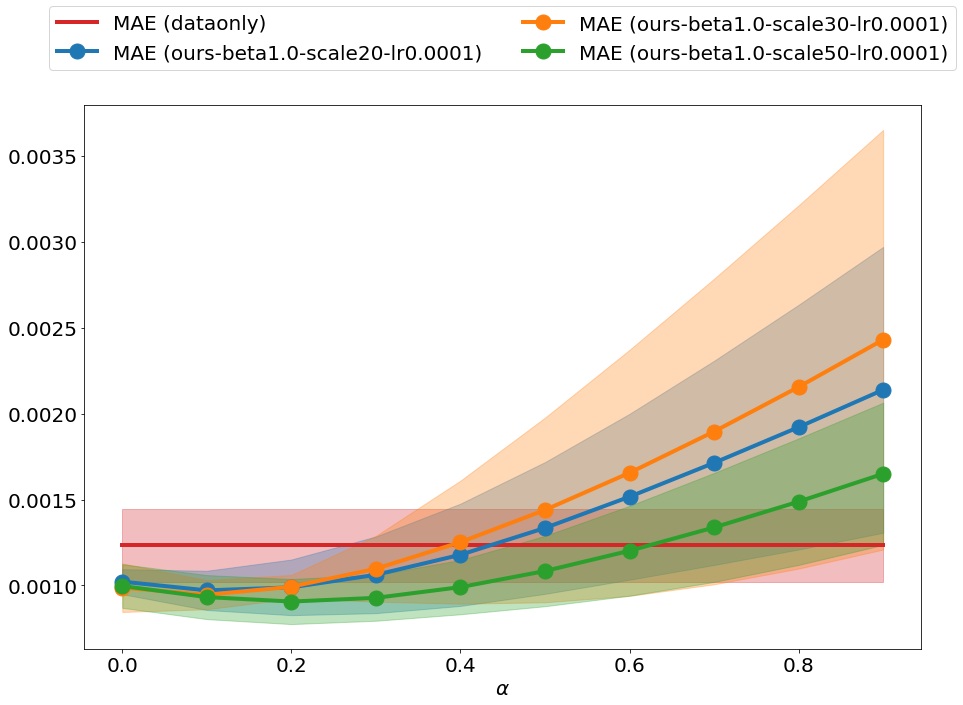

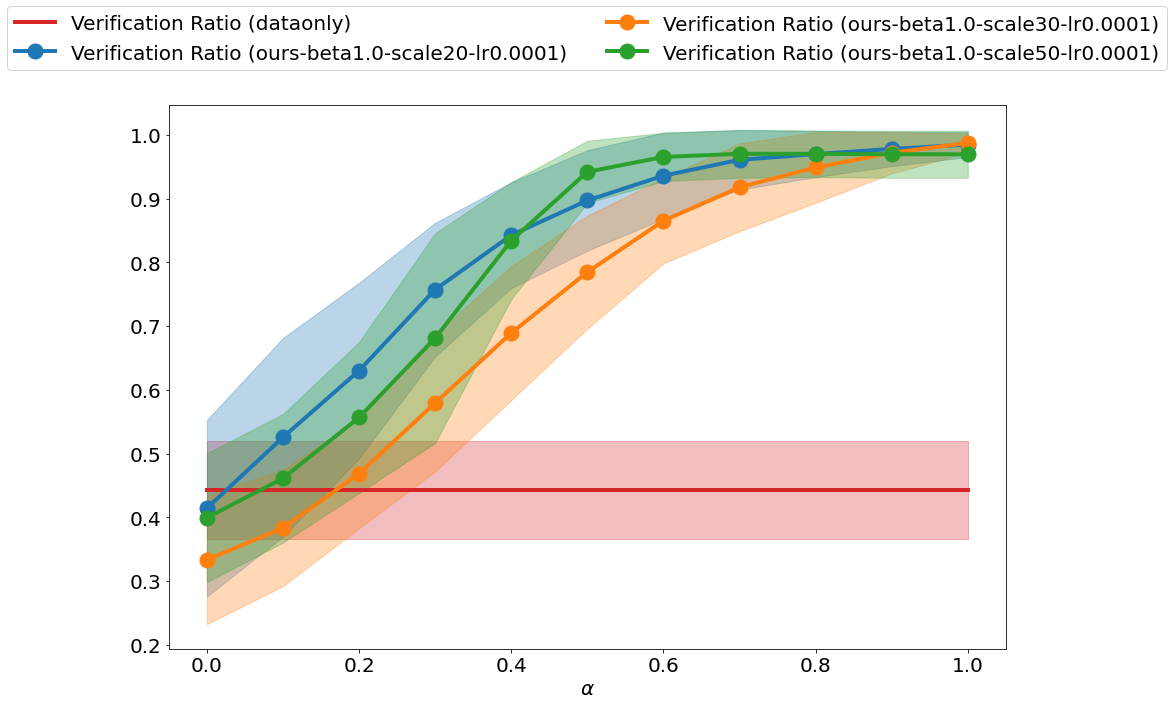

In [41]:
colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']*20
alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

for key, val in ret_dict.items():
    test_loss_list = []
    test_ratio_list = []
    for seed, subval in val.items():
        if isinstance(seed, int):
            test_loss_list.append(subval['test_loss'])
            test_ratio_list.append(subval['test_ratio'])
            
    val['test_loss_avg'] = np.mean(np.array(test_loss_list), 0)
    val['test_loss_std'] = np.std(np.array(test_loss_list), 0)
    val['test_ratio_avg'] = np.mean(np.array(test_ratio_list), 0)
    val['test_ratio_std'] = np.std(np.array(test_ratio_list), 0)


# key_list = ['dataonly', 'ours-beta1.0', 'ours-beta0.1']
# key_list = ['dataonly', 'ours-beta1.0', 'ours-beta1.0-scale10', 'ours-beta1.0-scale100', 'ours-beta1.0-scale1000']
# key_list = ['dataonly', 'ours-beta0.1', 'ours-beta0.1-scale10', 'ours-beta0.1-scale100', 'ours-beta0.1-scale1000']
# key_list = ['dataonly', 'ours-beta1.0', 'ours-beta1.0-scale10', 'ours-beta1.0-scale20', 'ours-beta1.0-scale50']
# key_list = ['dataonly', 'ours-beta0.1', 'ours-beta0.1-scale10', 'ours-beta0.1-scale20', 'ours-beta0.1-scale50']

# key_list = ['dataonly', 'ours-beta1.0-scale10', 'ours-beta1.0-scale10-lr0.0001']
# key_list = ['dataonly', 'ours-beta0.1-scale10', 'ours-beta0.1-scale10-lr0.0001']

# key_list = ['dataonly', 'ours-beta1.0-scale20', 'ours-beta1.0-scale20-lr0.0001', 'ours-beta1.0-scale50', 'ours-beta1.0-scale50-lr0.0001']
# key_list = ['dataonly', 'ours-beta0.1-scale20', 'ours-beta0.1-scale20-lr0.0001', 'ours-beta0.1-scale50', 'ours-beta0.1-scale50-lr0.0001']

key_list = ['dataonly', 'ours-beta1.0-scale20-lr0.0001', 'ours-beta1.0-scale30-lr0.0001', 'ours-beta1.0-scale50-lr0.0001']

i, ii = 0, 10
plt.figure(0, figsize=(15,10))
for key in key_list:
    val = ret_dict[key]
    ltype = '-' if key.startswith('dataonly') else 'o-'
    plt.plot(alphas[:ii], val['test_loss_avg'][:ii], ltype, color=colors[i], lw=4, ms=15, label='MAE ({})'.format(key))
    plt.fill_between(alphas[:ii], val['test_loss_avg'][:ii] - val['test_loss_std'][:ii], val['test_loss_avg'][:ii] + val['test_loss_std'][:ii], color=colors[i], alpha=0.3)
    i += 1
    
plt.xlabel(r'$\alpha$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20, bbox_to_anchor=(0.5, 1.2), ncol=2, loc='upper center')
# plt.ylim(0.0007, 0.003)


plt.figure(1, figsize=(15,10))
i = 0
for key in key_list:
    val = ret_dict[key]
    ltype = '-' if key.startswith('dataonly') else 'o-'
    plt.plot(alphas, val['test_ratio_avg'], ltype, color=colors[i], lw=4, ms=15, label='Verification Ratio ({})'.format(key))
    plt.fill_between(alphas, val['test_ratio_avg'] - val['test_ratio_std'], val['test_ratio_avg'] + val['test_ratio_std'], color=colors[i], alpha=0.3)
    i += 1

plt.xlabel(r'$\alpha$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20, bbox_to_anchor=(0.5, 1.2), ncol=2, loc='upper center')

In [174]:
ret_dict.keys()

dict_keys(['dataonly', 'ours-beta1.0-scale10', 'ours-beta0.1-scale10'])

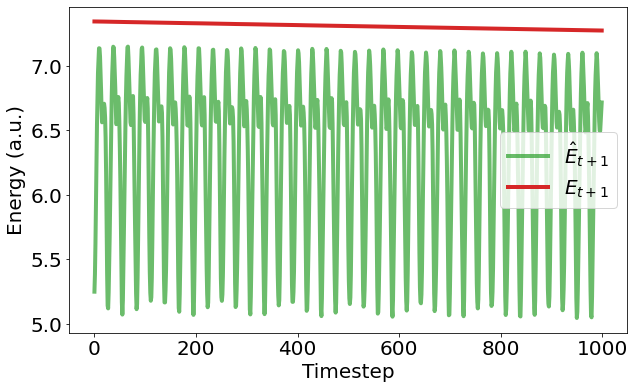

In [200]:
import matplotlib as mpl

# mpl.style.use('default')

fig, ax = plt.subplots(figsize=(10,6))

# ax.plot(curr_E.cpu().numpy()[:1000], '-', color='tab:blue', lw=4, ms=10, alpha=1.0, label=r'$E_t$')
ax.plot(pred_E.cpu().numpy()[:1000], '-', color='tab:green', lw=4, ms=10, alpha=0.7, label=r'$\hat{E}_{t+1}$')
ax.plot(next_E.cpu().numpy()[:1000], '-', color='tab:red', lw=4, ms=10, alpha=1.0, label=r'$E_{t+1}$')

plt.xlabel('Timestep', fontsize=20)
plt.ylabel('Energy (a.u.)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.yticks([])
plt.legend(fontsize=20)

# plt.savefig('img/dp-data-only.pdf', bbox_inches='tight')
# plt.savefig('img/dp-hybrid.pdf', bbox_inches='tight')

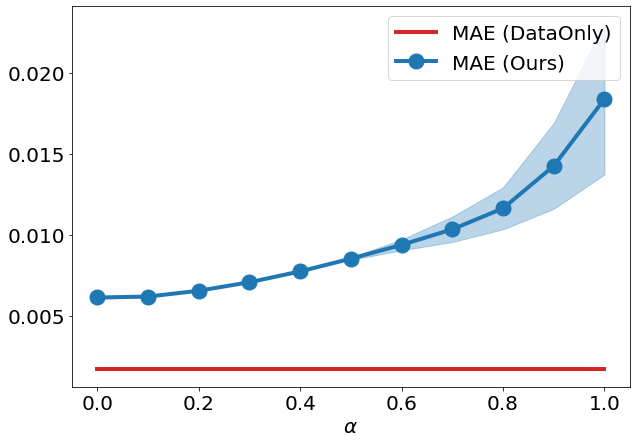

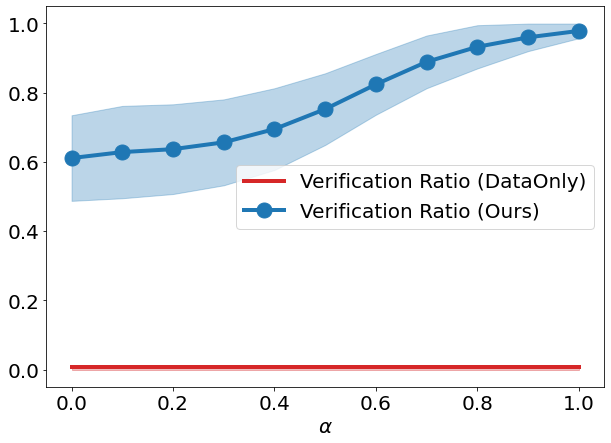

In [132]:
ret_hybrid = {'test_loss': [], 'test_ratio': []}
ret_dataonly = {'test_loss': [], 'test_ratio': []}
for model_type, val in ret_dict.items():
    for seed, subval in val.items():
        if model_type == 'dataonly':
            ret_dataonly['test_loss'].append(subval['test_loss'])
            ret_dataonly['test_ratio'].append(subval['test_ratio'])
        elif model_type == 'hybrid':
            ret_hybrid['test_loss'].append(subval['test_loss'])
            ret_hybrid['test_ratio'].append(subval['test_ratio'])
            

dataonly_loss_mean = np.mean(np.array(ret_dataonly['test_loss']), 0)
hybrid_loss_mean = np.mean(np.array(ret_hybrid['test_loss']), 0)
dataonly_loss_std = np.std(np.array(ret_dataonly['test_loss']), 0)
hybrid_loss_std = np.std(np.array(ret_hybrid['test_loss']), 0)

dataonly_ratio_mean = np.mean(np.array(ret_dataonly['test_ratio']), 0)
hybrid_ratio_mean = np.mean(np.array(ret_hybrid['test_ratio']), 0)
dataonly_ratio_std = np.std(np.array(ret_dataonly['test_ratio']), 0)
hybrid_ratio_std = np.std(np.array(ret_hybrid['test_ratio']), 0)


plt.figure(0, figsize=(10,7))
plt.plot(alphas, dataonly_loss_mean, '-', color='tab:red', lw=4, label='MAE (DataOnly)')
plt.fill_between(alphas, dataonly_loss_mean - dataonly_loss_std, dataonly_loss_mean + dataonly_loss_std, color='tab:red', alpha=0.3)
plt.plot(alphas, hybrid_loss_mean, 'o-', color='tab:blue', lw=4, markersize=15, label='MAE (Ours)')
plt.fill_between(alphas, hybrid_loss_mean - hybrid_loss_std, hybrid_loss_mean + hybrid_loss_std, color='tab:blue', alpha=0.3)
# plt.errorbar(alphas, np.mean(np.array(ret_dataonly['test_loss']), 0), yerr=np.std(ret_dataonly['test_loss'], 0), color='tab:red', lw=4, label='MAE (DataOnly)')
# plt.errorbar(alphas, np.mean(np.array(ret_hybrid['test_loss']), 0), yerr=np.std(ret_hybrid['test_loss'],0), color='tab:blue', lw=4, markersize=15, label='MAE (Ours)')
plt.xlabel(r'$\alpha$', fontsize=20)
# plt.ylabel('Verification ratio', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)


plt.figure(1, figsize=(10,7))
# plt.plot(alphas, np.mean(np.array(ret_dataonly['test_ratio']), 0), '-', color='tab:red', lw=4, label='Verification Ratio (DataOnly)')
# plt.plot(alphas, np.mean(np.array(ret_hybrid['test_ratio']), 0), 'o-', color='tab:blue', lw=4, markersize=15, label='Verification Ratio (Ours)')
plt.plot(alphas, dataonly_ratio_mean, '-', color='tab:red', lw=4, label='Verification Ratio (DataOnly)')
plt.fill_between(alphas, dataonly_ratio_mean - dataonly_ratio_std, dataonly_ratio_mean + dataonly_ratio_std, color='tab:red', alpha=0.3)
plt.plot(alphas, hybrid_ratio_mean, 'o-', color='tab:blue', lw=4, markersize=15, label='Verification Ratio (Ours)')
plt.fill_between(alphas, hybrid_ratio_mean - hybrid_ratio_std, hybrid_ratio_mean + hybrid_ratio_std, color='tab:blue', alpha=0.3)
plt.xlabel(r'$\alpha$', fontsize=20)
# plt.ylabel('Verification ratio', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

In [32]:
ddd[0].shape, ddd[1].shape

(torch.Size([2, 10, 4]), torch.Size([2, 4]))